In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from constants import *

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold

In [5]:
df = pd.read_csv('data/Balanced.csv')

In [6]:
df = df.drop(['proto', 'state'], axis=1)
df = df.sample(frac=1)

In [7]:
X = StandardScaler().fit_transform(df.drop(['attack'], axis=1).values)
y = df.attack.values

In [8]:
# Hold-out
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3)

In [9]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, AUC
from tensorflow.keras.losses import BinaryCrossentropy


def make_model(input_shape):
    input_layer = Input(shape=input_shape)
    sequence = Sequential([
        Dense(32, activation="relu"),
        Dropout(0.25),
        Dense(16, activation="relu"),
        Dropout(0.25),
        Dense(1, activation="sigmoid"),
    ])

    tensor = sequence(input_layer)

    model = Model(input_layer, tensor)
    
    model.compile(loss='binary_crossentropy', 
        optimizer=Adam(0.002, 0.5), 
        metrics=['accuracy'])
    
    return model

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
    f1_score, roc_curve, auc


def train(model, X_train, y_train, verbose=True, show_graphs=True):
    print('*** TRAIN ***')
    
    fit_results = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=15,
        verbose=verbose
    )
    
    model.save('model.h5')
    print('Model saved: \'{}\''.format(PATH_MODEL))
    
    if show_graphs:
        f, ax = plt.subplots(2, 1, figsize=(12, 24))
        ax[0].set_title('Train accuracy')
        ax[0].plot(fit_results.history['accuracy'])
        ax[0].plot(fit_results.history['val_accuracy'])
        ax[0].grid()
        ax[0].legend(['Train', 'Validation'])
        
        ax[1].set_title('Train loss')
        ax[1].plot(fit_results.history['loss'])
        ax[1].plot(fit_results.history['val_loss'])
        ax[1].legend(['Train', 'Validation'])
        ax[1].grid()
    
        plt.show()
    
def test(model, X_test, y_test, thresholder=0.5, show_graphs=True, show_logs=True):
    print('*** TEST ***')
    
    y_score = model.predict(X_test)
    y_pred = 1*(y_score > thresholder)
    
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    re = recall_score(y_test, y_pred)
    f_score = f1_score(y_test, y_pred)
    
    if show_logs:
        print('Accuracy: {}'.format(acc))
        print('Precision: {}'.format(pre))
        print('Recall: {}'.format(re))
        print('F-score: {}'.format(f_score))    
    
    tpr, fpr, thrs = roc_curve(y_test, y_score)
    roc_auc = auc(tpr, fpr)
    
    if show_logs:
        print('AUC: {}'.format(roc_auc))
    
    if show_graphs:
        f, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.plot(tpr, fpr)
        ax.grid()
        ax.set_title('Roc curve')
        plt.show()
        
    return acc

*** TRAIN ***
Epoch 1/15
501/501 [==============================] - 2s 2ms/step - loss: 0.3567 - accuracy: 0.9078 - val_loss: 0.1817 - val_accuracy: 0.9486
Epoch 2/15
501/501 [==============================] - 1s 2ms/step - loss: 0.2001 - accuracy: 0.9461 - val_loss: 0.1736 - val_accuracy: 0.9531
Epoch 3/15
501/501 [==============================] - 1s 2ms/step - loss: 0.1926 - accuracy: 0.9477 - val_loss: 0.1671 - val_accuracy: 0.9548
Epoch 4/15
501/501 [==============================] - 1s 2ms/step - loss: 0.1819 - accuracy: 0.9499 - val_loss: 0.1558 - val_accuracy: 0.9561
Epoch 5/15
501/501 [==============================] - 1s 2ms/step - loss: 0.1625 - accuracy: 0.9532 - val_loss: 0.1351 - val_accuracy: 0.9601
Epoch 6/15
501/501 [==============================] - 1s 2ms/step - loss: 0.1436 - accuracy: 0.9563 - val_loss: 0.1082 - val_accuracy: 0.9611
Epoch 7/15
501/501 [==============================] - 1s 2ms/step - loss: 0.1087 - accuracy: 0.9617 - val_loss: 0.0599 - val_accuracy:

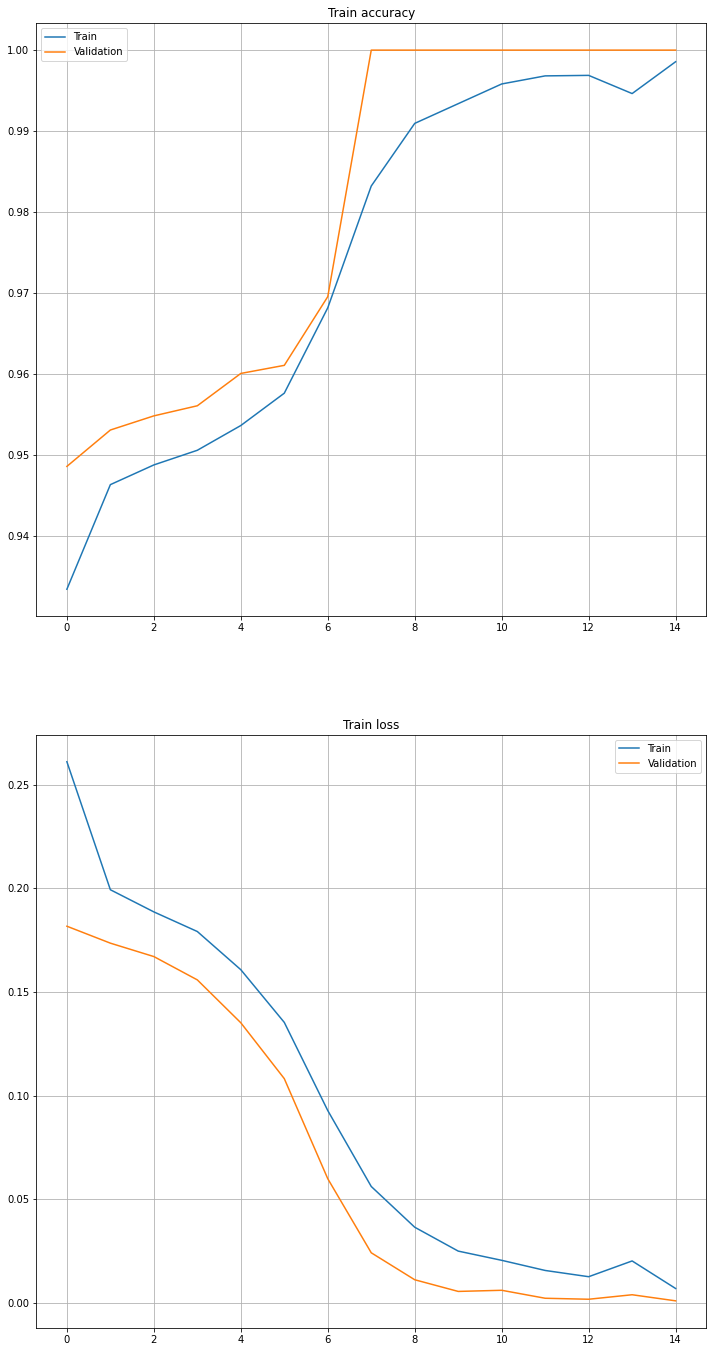

In [11]:
model = make_model(X[0].shape)
train(model, X_train, y_train)

*** TEST ***
Accuracy: 0.9996506753609687
Precision: 0.9994762569832403
Recall: 1.0
F-score: 0.9997380598969703
AUC: 0.9999436874930411


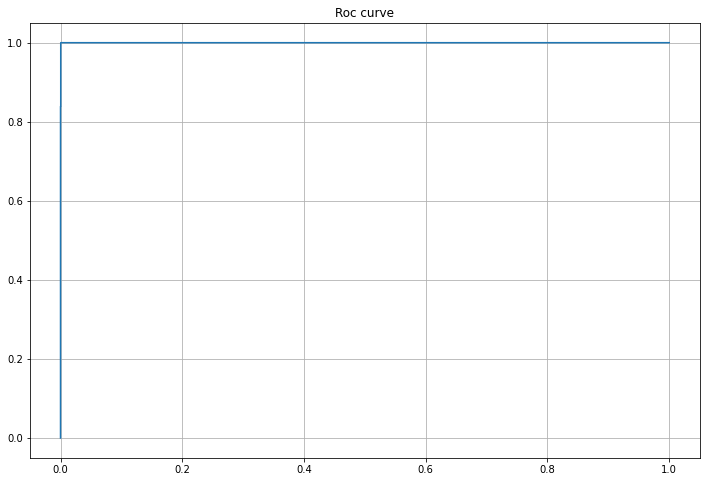

In [12]:
test(model, X_test, y_test)

In [16]:
# Crossvalidation
kfold = KFold(5)

for k, (index_train, index_test) in enumerate(kfold.split(X)):
    model = make_model(X[0].shape)
    train(model, X[index_train], y[index_train], verbose=False, show_graphs=False)
    acc = test(model, X[index_test], y[index_test], show_logs=False, show_graphs=False)
    
    print('k = {}, accuracy = {}'.format(k, acc))

*** TRAIN ***
Model saved: 'model.h5'
*** TEST ***
k = 0, accuracy = 0.9998253580160671
*** TRAIN ***
Model saved: 'model.h5'
*** TEST ***
k = 1, accuracy = 0.999825327510917
*** TRAIN ***
Model saved: 'model.h5'
*** TEST ***
k = 2, accuracy = 0.999650655021834
*** TRAIN ***
Model saved: 'model.h5'
*** TEST ***
k = 3, accuracy = 0.999650655021834
*** TRAIN ***
Model saved: 'model.h5'
*** TEST ***
k = 4, accuracy = 0.999650655021834
